In [2]:
import xml.etree.ElementTree as ET
import pandas as pd
import nltk
from nltk.corpus import wordnet as wn

# nltk.download('wordnet')

In [3]:
semcor_training_xml = 'WSD_Evaluation_Framework/Training_Corpora/Semcor/semcor.data.xml'

tree = ET.parse(semcor_training_xml)
root = tree.getroot()

# Extract sentences and instances
data = []
for text in root.findall('text'):
    for sentence in text.findall('sentence'):
        sentence_id = sentence.get('id')
        sentence_text = ' '.join([element.text for element in sentence])
        for instance in sentence.findall('instance'):
            instance_id = instance.get('id')
            lemma = instance.get('lemma')
            pos = instance.get('pos')
            word = instance.text
            data.append([sentence_id, instance_id, lemma, pos, word, sentence_text])

# Create a DataFrame
columns = ['sentence_id', 'instance_id', 'lemma', 'pos', 'word', 'sentence_text']
xml_data = pd.DataFrame(data, columns=columns)

# Display the first few rows
xml_data.head()

,sentence_id,instance_id,lemma,pos,word,sentence_text
0,d000.s000,d000.s000.t000,long,ADJ,long,How long has it been since you reviewed the ob...
1,d000.s000,d000.s000.t001,be,VERB,been,How long has it been since you reviewed the ob...
2,d000.s000,d000.s000.t002,review,VERB,reviewed,How long has it been since you reviewed the ob...
3,d000.s000,d000.s000.t003,objective,NOUN,objectives,How long has it been since you reviewed the ob...
4,d000.s000,d000.s000.t004,benefit,NOUN,benefit,How long has it been since you reviewed the ob...


In [4]:
semcor_training_gold_key = 'WSD_Evaluation_Framework/Training_Corpora/Semcor/semcor.gold.key.txt'

# Parse the gold key file
gold_data = []
with open(semcor_training_gold_key, 'r') as file:
    for line in file:
        parts = line.strip().split()
        instance_id = parts[0]
        sense_id = parts[1]
        gold_data.append([instance_id, sense_id])

# Create a DataFrame
gold_columns = ['instance_id', 'sense_id']
gold_df = pd.DataFrame(gold_data, columns=gold_columns)

# Display the first few rows
gold_df.head()


,instance_id,sense_id
0,d000.s000.t000,long%3:00:02::
1,d000.s000.t001,be%2:42:03::
2,d000.s000.t002,review%2:31:00::
3,d000.s000.t003,objective%1:09:00::
4,d000.s000.t004,benefit%1:21:00::


In [5]:
# Merge the dataframes on 'instance_id'
merged_data = pd.merge(xml_data, gold_df, on='instance_id', how='inner')

# Display the first few rows
merged_data.head()

,sentence_id,instance_id,lemma,pos,word,sentence_text,sense_id
0,d000.s000,d000.s000.t000,long,ADJ,long,How long has it been since you reviewed the ob...,long%3:00:02::
1,d000.s000,d000.s000.t001,be,VERB,been,How long has it been since you reviewed the ob...,be%2:42:03::
2,d000.s000,d000.s000.t002,review,VERB,reviewed,How long has it been since you reviewed the ob...,review%2:31:00::
3,d000.s000,d000.s000.t003,objective,NOUN,objectives,How long has it been since you reviewed the ob...,objective%1:09:00::
4,d000.s000,d000.s000.t004,benefit,NOUN,benefit,How long has it been since you reviewed the ob...,benefit%1:21:00::


In [20]:
def format_sense_id(sense_id):
    try:
        # Split the sense_id by '%'
        parts = sense_id.split('%')
        if len(parts) != 2:
            return None  # Invalid format
        
        lemma = parts[0]
        sense_info = parts[1].split(':')
        
        # Ensure there are enough parts
        if len(sense_info) < 2:
            return None  # Invalid format
        
        # Convert WordNet POS tags
        pos_mapping = {'1': 'n', '2': 'v', '3': 'a', '4': 'r'}
        pos = pos_mapping.get(sense_info[0], None)
        if not pos:
            return None  # Invalid POS
        
        # Combine to form a WordNet synset id
        synset_id = f"{lemma}.{pos}.{sense_info[2].zfill(2)}"
        return synset_id
    except Exception as e:
        # If any error occurs, return None
        return None

def is_valid_sense(sense_id):
    formatted_sense_id = format_sense_id(sense_id)
    if not formatted_sense_id:
        return False
    try:
        wn.synset(formatted_sense_id)
        return True
    except nltk.corpus.reader.wordnet.WordNetError:
        return False

# Apply the function to the merged dataset
merged_data['formatted_sense_id'] = merged_data['sense_id'].apply(format_sense_id)
# merged_data['valid_sense'] = merged_data['formatted_sense_id'].apply(is_valid_sense)

# Check for any invalid sense IDs
invalid_senses = merged_data[~merged_data['valid_sense']]
print(f'Number of invalid sense IDs: {invalid_senses.shape[0]}')

# # Display invalid senses if any
# if not invalid_senses.empty:
#     display(invalid_senses)
display(merged_data.head())

Number of invalid sense IDs: 226036


,sentence_id,instance_id,lemma,pos,word,sentence_text,sense_id,formatted_sense_id,valid_sense,context_length
0,d000.s000,d000.s000.t000,long,ADJ,long,How long has it been since you reviewed the ob...,long%3:00:02::,long.a.02,False,17
1,d000.s000,d000.s000.t001,be,VERB,been,How long has it been since you reviewed the ob...,be%2:42:03::,be.v.03,False,17
2,d000.s000,d000.s000.t002,review,VERB,reviewed,How long has it been since you reviewed the ob...,review%2:31:00::,review.v.00,False,17
3,d000.s000,d000.s000.t003,objective,NOUN,objectives,How long has it been since you reviewed the ob...,objective%1:09:00::,objective.n.00,False,17
4,d000.s000,d000.s000.t004,benefit,NOUN,benefit,How long has it been since you reviewed the ob...,benefit%1:21:00::,benefit.n.00,False,17


In [23]:
synset = wn.synset('long.a.01')

print(synset)
print(synset.definition())

Synset('long.a.01')
primarily temporal sense; being or indicating a relatively great or greater than average duration or passage of time or a duration as specified


In [22]:
# Get all adjective synsets for 'long'
long_adjective_synsets = wn.synsets('long', pos=wn.ADJ)

# Display synsets and definitions
for synset in long_adjective_synsets:
    print(f'{synset.name()}: {synset.definition()}')


long.a.01: primarily temporal sense; being or indicating a relatively great or greater than average duration or passage of time or a duration as specified
long.a.02: primarily spatial sense; of relatively great or greater than average spatial extension or extension as specified
long.s.03: of relatively great height; - Sherwood Anderson
retentive.a.01: good at remembering
long.a.05: holding securities or commodities in expectation of a rise in prices
long.a.06: (of speech sounds or syllables) of relatively long duration
long.s.07: involving substantial risk
farseeing.s.02: planning prudently for the future
long.s.09: having or being more than normal or necessary:


count    226036.000000
mean         30.436094
std          18.471977
min           2.000000
25%          18.000000
50%          27.000000
75%          38.000000
max         270.000000
Name: context_length, dtype: float64
be%2:42:03::          10088
person%1:03:00::       6696
be%2:42:06::           2945
not%4:02:00::          1703
say%2:32:00::          1684
group%1:03:00::        1328
have%2:40:00::         1150
location%1:03:00::      989
be%2:42:05::            800
be%2:42:00::            692
Name: sense_id, dtype: int64


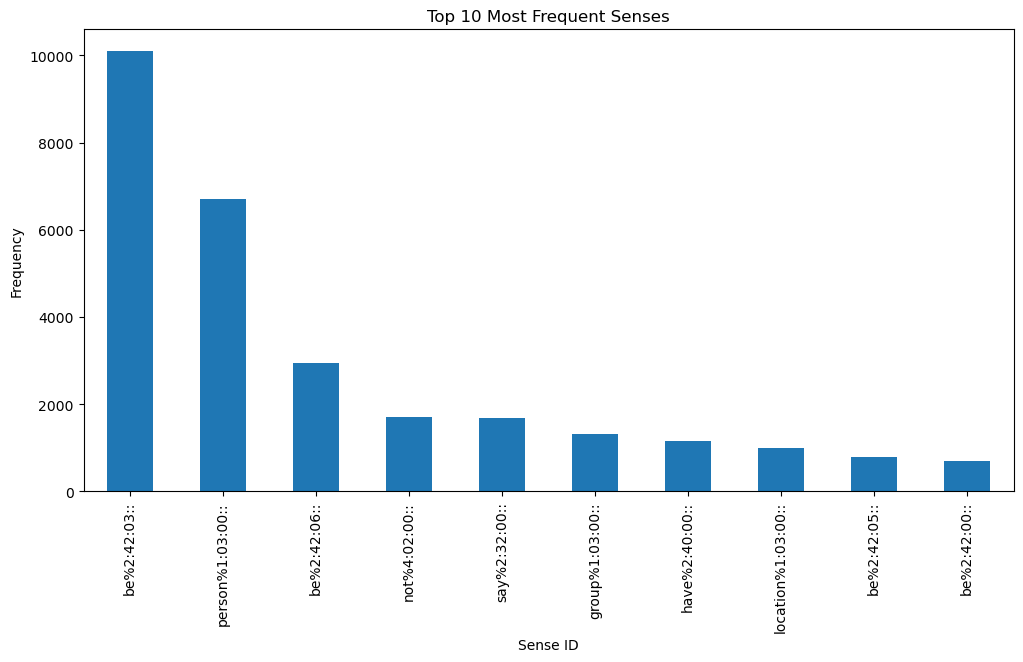

In [7]:
# Context length analysis
merged_data['context_length'] = merged_data['sentence_text'].apply(lambda x: len(x.split()))

# Display basic statistics about context length
context_length_stats = merged_data['context_length'].describe()
print(context_length_stats)

# Sense distribution
sense_distribution = merged_data['sense_id'].value_counts()
print(sense_distribution.head(10))  # Display the top 10 most frequent senses

import matplotlib.pyplot as plt

# Plot the sense distribution
plt.figure(figsize=(12, 6))
sense_distribution.head(10).plot(kind='bar')
plt.title('Top 10 Most Frequent Senses')
plt.xlabel('Sense ID')
plt.ylabel('Frequency')
plt.show()


In [8]:
def get_example_sentences(word, sense_id, data, num_examples=5):
    examples = data[(data['word'] == word) & (data['sense_id'] == sense_id)]
    return examples['sentence_text'].head(num_examples)

# Example usage
word = 'program'
sense_id = 'program%1:09:01'  # Use a valid sense ID for the word
examples = get_example_sentences(word, sense_id, merged_data)

print(f'Example sentences for word "{word}" with sense "{sense_id}":')
for i, sentence in enumerate(examples, 1):
    print(f'{i}. {sentence}')


Example sentences for word "program" with sense "program%1:09:01":


In [28]:
def load_ball_embeddings(bFile=''):
    """
    :param bFile:
    :return:
    """
    print("loading balls....")
    nball_list = []
    with open(bFile, 'r') as w2v:
        for line in w2v.readlines():
            wlst = line.strip().split()
            nball_list.append(wlst[0])
    print(len(nball_list),' balls are loaded\n')
    return nball_list

nball_list = load_ball_embeddings('training_set\word2vec.txt')
nball_list.append('be.v.01')
nball_list.append('be.v.02')
small_set = merged_data[merged_data['formatted_sense_id'].isin(nball_list)]
small_set

loading balls....
7586  balls are loaded



,sentence_id,instance_id,lemma,pos,word,sentence_text,sense_id,formatted_sense_id,valid_sense,context_length
4305,d004.s021,d004.s021.t000,be,VERB,was,"It was a brilliant debut , so much so indeed t...",be%2:42:02::,be.v.02,False,28
4457,d004.s036,d004.s036.t003,be,VERB,Is,To get it out into the daylight 's glow Is my ...,be%2:42:02::,be.v.02,False,22
4467,d004.s038,d004.s038.t002,be,VERB,is,"That little spark is all the wealth I know , T...",be%2:42:02::,be.v.02,False,20
4472,d004.s038,d004.s038.t007,be,VERB,is,"That little spark is all the wealth I know , T...",be%2:42:02::,be.v.02,False,20
4616,d004.s053,d004.s053.t003,be,VERB,was,Strindberg 's remedy for this condition was to...,be%2:42:02::,be.v.02,False,21
...,...,...,...,...,...,...,...,...,...,...
220371,d330.s057,d330.s057.t000,be,VERB,is,That is one thing the experiments are designed...,be%2:42:02::,be.v.02,False,12
221716,d335.s039,d335.s039.t001,be,VERB,are,"In `` Donnybrook '' , there is quite a differe...",be%2:42:02::,be.v.02,False,27
222731,d338.s113,d338.s113.t003,be,VERB,was,He had promised cheaper housing : arbitrarily ...,be%2:42:02::,be.v.02,False,35
225675,d350.s033,d350.s033.t000,be,VERB,is,But Albania is merely a symptom of a real mala...,be%2:42:02::,be.v.02,False,15
